In [21]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
import pandas as pd
import json
import torch
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt
from typing import List, Dict, Tuple
from scipy.stats import linregress
from sae_lens.toolkit.pretrained_saes import get_gpt2_res_jb_saes
import plotly_express as px
import numpy as np
import seaborn as sns
from glob import glob
from memory_profiler import profile

In [23]:
def get_device_str() -> str:
    if torch.backends.mps.is_available():
        return "mps"
    else:
        return "cuda" if torch.cuda.is_available() else "cpu"


def load_jsonl(file_path):
    data = []
    with open(file_path, "r") as file:
        for line in file:
            # Parse each line as a JSON object
            json_object = json.loads(line.strip())
            data.append(json_object)
    return data


def find_kl_div_blowup(steps: List[Dict], threshold: float = 0.5) -> Tuple[int, float]:
    for step in steps:
        if step["kl_div"] >= threshold:
            return step["step"]
    # Return the last step and its normalized KL div if threshold is never reached
    return len(steps)


def classify_perturbation_type(steps: List[Dict]) -> str:
    kl_divs = [step["kl_div"] for step in steps]

    # Check for initial plateau
    initial_slope = linregress(range(10), kl_divs[:10]).slope

    # Check for rapid increase
    max_slope = max(kl_divs[i + 1] - kl_divs[i] for i in range(len(kl_divs) - 1))

    if initial_slope < 0.01 and max_slope > 0.1:
        return "plateau_then_rapid"
    elif all(kl_divs[i] <= kl_divs[i + 1] for i in range(len(kl_divs) - 1)):
        return "monotonic_increase"
    else:
        return "other"


def compute_prompt_embedding(prompt: List[int], model) -> np.ndarray:
    with torch.no_grad():
        # Convert token IDs to tensor
        tokens_tensor = torch.tensor(prompt).unsqueeze(0)  # Add batch dimension
        # Get embeddings
        embeddings = model.embed(tokens_tensor)
        # Average embeddings across token dimension
        mean_embedding = embeddings.mean(dim=1)
    return mean_embedding


def compute_prompt_cosine_sim(start_prompt, end_prompt, model):
    start_emb = compute_prompt_embedding(start_prompt, model)
    end_emb = compute_prompt_embedding(end_prompt, model)
    return torch.cosine_similarity(start_emb, end_emb).item()

## Finding KL div threshold

In [24]:
raw_observations = []

for filepath in glob("observations/*"):
    obs_data = load_jsonl(filepath)
    raw_observations.extend(obs_data)

In [26]:
len(raw_observations)

20000

### Deal with duplicates

In [6]:
seen = set()
raw_observations_deduped = []

for obs in raw_observations:
    prompt_id = " ".join([str(t) for t in obs["start_prompt"] + obs["end_prompt"]])
    if prompt_id in seen:
        continue

    raw_observations_deduped.append(obs)
    seen.add(prompt_id)

In [9]:
from datetime import datetime
import os


def reduce_float_precision(obj, precision=6):
    if isinstance(obj, float):
        return float(np.round(obj, precision))
    elif isinstance(obj, dict):
        return {k: reduce_float_precision(v, precision) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [reduce_float_precision(i, precision) for i in obj]
    return obj


def save_observations_to_disk(observations, base_dir="observations", precision=6):
    if not observations:
        return

    os.makedirs(base_dir, exist_ok=True)
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    filename = f"observations_{len(observations)}_{timestamp}.jsonl"
    filepath = os.path.join(base_dir, filename)

    with open(filepath, "w") as f:
        for obs in observations:
            reduced_obs = reduce_float_precision(obs, precision)
            json.dump(reduced_obs, f)
            f.write("\n")

    print(f"Saved {len(observations)} observations to {filepath}")

In [10]:
save_observations_to_disk(raw_observations_deduped)

Saved 20000 observations to observations/observations_20000_20240806_095010.jsonl


In [7]:
len(raw_observations_deduped)

20000

In [7]:
# Run this analysis on your observations
# analyze_kl_div_distribution(raw_observations)

## Processing observations data

In [27]:
from transformer_lens import HookedTransformer
from collections import Counter, defaultdict

In [28]:
model = HookedTransformer.from_pretrained("gpt2")
device = get_device_str()

print(device)

Loaded pretrained model gpt2 into HookedTransformer
cuda


In [29]:
perturbation_layer = "blocks.0.hook_resid_pre"
saes, sparsities = get_gpt2_res_jb_saes(perturbation_layer)
sae = saes[perturbation_layer].cpu()
feature_sparsities = 10 ** sparsities[perturbation_layer].cpu()

sae.eval()

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.87it/s]


SAE(
  (activation_fn): ReLU()
  (hook_sae_input): HookPoint()
  (hook_sae_acts_pre): HookPoint()
  (hook_sae_acts_post): HookPoint()
  (hook_sae_output): HookPoint()
  (hook_sae_recons): HookPoint()
  (hook_sae_error): HookPoint()
)

In [54]:
def get_active_features_properties_sorted(step):
    feature_acts_total = sum(step["active_feature_acts"])
    active_feature_acts_norm = [
        round(a / feature_acts_total, 2) for a in step["active_feature_acts"]
    ]
    active_features_act_spars = sorted(
        zip(
            step["active_feature_ids"],
            step["active_feature_acts"],
            active_feature_acts_norm,
            step["active_feature_sparsities"],
        ),
        key=lambda x: x[1],
        reverse=True,
    )
    return active_features_act_spars


def get_top_features_act(step, step_id):
    active_features_act_spars = get_active_features_properties_sorted(step)
    (
        (feat1, act1, act_norm1, spars1),
        (feat2, act2, act_norm2, spars2),
        (feat3, act3, act_norm3, spars3),
    ) = active_features_act_spars[:3]

    feat1_dir = get_feature_dir(sae, feat1)
    feat2_dir = get_feature_dir(sae, feat2)
    feat3_dir = get_feature_dir(sae, feat3)

    feat1_feat2_cos_sim = torch.cosine_similarity(
        feat1_dir.unsqueeze(0), feat2_dir.unsqueeze(0)
    ).item()
    feat1_feat3_cos_sim = torch.cosine_similarity(
        feat1_dir.unsqueeze(0), feat3_dir.unsqueeze(0)
    ).item()
    feat2_feat3_cos_sim = torch.cosine_similarity(
        feat2_dir.unsqueeze(0), feat3_dir.unsqueeze(0)
    ).item()

    feat1_l0_inverse_recon = calculate_l0(sae.encode(feat1_dir))
    feat2_l0_inverse_recon = calculate_l0(sae.encode(feat2_dir))
    feat3_l0_inverse_recon = calculate_l0(sae.encode(feat3_dir))

    return {
        f"{step_id}_act_top_1_sae_feature_id": feat1,
        f"{step_id}_act_top_1_sae_feature_act": act1,
        f"{step_id}_act_top_1_sae_feature_act_norm": act_norm1,
        f"{step_id}_act_top_1_sae_feature_sparsity": spars1,
        f"{step_id}_act_top_2_sae_feature_id": feat2,
        f"{step_id}_act_top_2_sae_feature_act": act2,
        f"{step_id}_act_top_2_sae_feature_act_norm": act_norm2,
        f"{step_id}_act_top_2_sae_feature_sparsity": spars2,
        f"{step_id}_act_top_3_sae_feature_id": feat3,
        f"{step_id}_act_top_3_sae_feature_act": act3,
        f"{step_id}_act_top_3_sae_feature_act_norm": act_norm3,
        f"{step_id}_act_top_3_sae_feature_sparsity": spars3,
        f"{step_id}_act_l2_norm": step["l2_norm"],
        f"{step_id}_feat1_feat2_cos_sim": round(feat1_feat2_cos_sim, 4),
        f"{step_id}_feat1_feat3_cos_sim": round(feat1_feat3_cos_sim, 4),
        f"{step_id}_feat2_feat3_cos_sim": round(feat2_feat3_cos_sim, 4),
        f"{step_id}_feat1_l0_inv_recon": feat1_l0_inverse_recon,
        f"{step_id}_feat2_l0_inv_recon": feat2_l0_inverse_recon,
        f"{step_id}_feat3_l0_inv_recon": feat3_l0_inverse_recon,
    }


def sae_derived_features(steps):
    num_steps = len(steps)
    all_active_features = [
        feature for step in steps for feature in step["active_feature_ids"]
    ]
    feature_counts = Counter(all_active_features)

    sae_features = {
        k: v
        for step_id, step in enumerate(steps)
        for k, v in get_top_features_act(step, step_id).items()
        if step_id % 5 == 0
    }

    return {
        "total_unique_active_features": len(feature_counts),
        "avg_feature_activation_count": (
            round((sum(feature_counts.values()) / len(feature_counts)) / num_steps, 4)
            if feature_counts
            else 0
        ),
        "avg_active_features": np.mean([step["num_active_features"] for step in steps]),
        "std_active_features": np.std([step["num_active_features"] for step in steps]),
        "avg_feature_activation": np.mean(
            [np.mean(step["active_feature_acts"]) for step in steps]
        ),
        "std_feature_activation": np.std(
            [np.mean(step["active_feature_acts"]) for step in steps]
        ),
        **sae_features,
    }


def find_plateau_length(steps: List[Dict], threshold: float = 0.01) -> int:
    kl_divs = [step["kl_div"] for step in steps]
    slopes = [kl_divs[i + 1] - kl_divs[i] for i in range(len(kl_divs) - 1)]

    for i, slope in enumerate(slopes):
        if abs(slope) > threshold:
            return i

    return len(steps) - 1


def calculate_l0(vector, threshold=0.05):
    return np.sum(np.abs(vector.detach().numpy()) > threshold)


def get_feature_dir(sae, feature_id_to_activate):
    feature_acts = torch.zeros(sae.W_enc.shape[1])

    # Activate the specified feature
    feature_acts[:] = 0
    feature_acts[feature_id_to_activate] = 1

    # Decode back to the residual stream space
    perturbed_act = sae.decode(feature_acts)

    return perturbed_act

In [37]:
sample_observation_ids = set(random.sample(range(0, len(raw_observations)), 1000))
sample_observations = [
    obs for i, obs in enumerate(raw_observations) if i in sample_observation_ids
]

In [55]:
observations_features = []
seq_len = 10

for i, obs in enumerate(sample_observations):
    token_sim = len(set(obs["start_prompt"]) & set(obs["end_prompt"])) / seq_len

    observations_features.append(
        {
            "id": obs["id"],
            "start_prompt": model.tokenizer.decode(obs["start_prompt"]),
            "end_prompt": model.tokenizer.decode(obs["end_prompt"]),
            "prompts_cos_sim": compute_prompt_cosine_sim(
                obs["start_prompt"], obs["end_prompt"], model
            ),
            "prompts_token_sim": token_sim,
            "kl_div_blowup_step": find_kl_div_blowup(obs["steps"]),
            "plateau_length": find_plateau_length(obs["steps"]),
            "perturbation_type": classify_perturbation_type(obs["steps"]),
            "final_kl_div": obs["steps"][-1]["kl_div"],
            "final_l2_norm": obs["steps"][-1]["l2_norm"],
            "final_cos_sim": obs["steps"][-1]["cos_sim"],
            **sae_derived_features(obs["steps"]),
        }
    )

    if i % 100 == 0:
        print(f"Processing observation {i}/{len(sample_observations)}")

df = pd.DataFrame(observations_features)

Processing observation 0/1000
Processing observation 100/1000
Processing observation 200/1000
Processing observation 300/1000
Processing observation 400/1000
Processing observation 500/1000
Processing observation 600/1000
Processing observation 700/1000
Processing observation 800/1000
Processing observation 900/1000


In [56]:
print(df.shape)
df.head()

(1000, 397)


,id,start_prompt,end_prompt,prompts_cos_sim,prompts_token_sim,kl_div_blowup_step,plateau_length,perturbation_type,final_kl_div,final_l2_norm,...,95_act_top_3_sae_feature_act,95_act_top_3_sae_feature_act_norm,95_act_top_3_sae_feature_sparsity,95_act_l2_norm,95_feat1_feat2_cos_sim,95_feat1_feat3_cos_sim,95_feat2_feat3_cos_sim,95_feat1_l0_inv_recon,95_feat2_l0_inv_recon,95_feat3_l0_inv_recon
0,2352e4bf-e2c5-4d58-8433-f170ec7d3ada,"strict, all-girls school in India. She",-WAIT I CHANGE MY MIND.,0.745210,0.2,46,39,plateau_then_rapid,8.923265,3.668503,...,0.391622,0.09,0.043999,3.520280,0.9754,0.9449,0.9864,1,0,1
1,a67ef94a-16c1-411e-a50b-6104279dfb5d,"strict, all-girls school in India. She",. Drugs are (or at least have been until,0.806345,0.1,50,43,plateau_then_rapid,5.600887,3.817001,...,0.506425,0.08,0.128111,3.662779,0.9153,0.9163,0.9988,1,0,0
2,03d4727a-5566-4924-aeff-313dadfd1a3e,’t think he should testify. So I,across the US\n\nPumped millions of gallons,0.758759,0.0,50,42,plateau_then_rapid,5.297598,4.352025,...,0.617660,0.09,0.119497,4.176185,0.9210,0.9192,0.9988,1,0,0
3,b007fa01-d291-47eb-beb6-beec951b0a8f,bolster their physical presence in order to u...,"..."" (8 comments)\n\nMaggie",0.713675,0.0,51,38,plateau_then_rapid,4.403311,4.366811,...,0.614883,0.09,0.119497,4.190374,0.9183,0.9178,0.9988,1,0,0
4,80d5dbe6-368c-415d-802c-6cb169b74378,United States.\n\nBut in a fit of,\nThe ultimate “Hulk vs. everybody,0.754049,0.2,48,40,plateau_then_rapid,7.943594,3.842147,...,0.663996,0.10,0.119497,3.686909,0.9349,0.9167,0.9158,1,1,0


In [57]:
df.to_feather("data/dataset_1k_more_feats.feather")

## Plotting observations data

In [18]:
df.sample(5)

,id,start_prompt,end_prompt,prompts_cos_sim,prompts_token_sim,kl_div_blowup_step,plateau_length,perturbation_type,final_kl_div,final_l2_norm,...,100_act_top_1_sae_feature_sparsity,100_act_top_2_sae_feature_id,100_act_top_2_sae_feature_act,100_act_top_2_sae_feature_act_norm,100_act_top_2_sae_feature_sparsity,100_act_top_3_sae_feature_id,100_act_top_3_sae_feature_act,100_act_top_3_sae_feature_act_norm,100_act_top_3_sae_feature_sparsity,100_act_l2_norm
7879,f198d569-4cfc-4c21-949c-3c7b9d8b0219,"catch on fire, according to Channel 2 Action ...",or diadzein) (Fang et,0.741424,0.0,61,51,plateau_then_rapid,3.351654,4.168866,...,0.000126,19064,0.495953,0.07,0.043999,15603,0.492113,0.07,0.119497,4.168866
12894,2156cb50-86ca-4e0f-b9f1-cbbf36fb4d7a,\nHere is a map of possible locations.<|endoft...,its military might. We already feel the trend of,0.844767,0.2,47,42,plateau_then_rapid,4.806298,3.244393,...,0.009461,19064,0.678461,0.14,0.043999,15603,0.514060,0.11,0.119497,3.244393
5005,5394f126-d304-4dee-88ec-dd82fdcd717f,"and are married. In the end, Shim Chong","today's video professional, the move to 4K",0.843932,0.2,42,25,plateau_then_rapid,3.042238,4.783825,...,0.000274,7550,0.615456,0.10,0.128111,15603,0.576867,0.09,0.119497,4.783825
17931,7e8fe70e-91e5-4505-aa5c-c842f3139cc0,"picture, and in total, arguably, if we",Advertisements<|endoftext|>I'm level 48 and i ...,0.707404,0.1,48,39,plateau_then_rapid,4.637140,4.114207,...,0.000455,15603,0.654668,0.06,0.119497,13062,0.612430,0.06,0.000351,4.114207
19481,daaf9413-b962-4aea-a277-6ce687e4f81f,campaign.\n\nIn a statement responding to claims,designs. Jobs hated them all. “No,0.749363,0.1,50,44,plateau_then_rapid,5.789344,3.749718,...,0.000134,7550,0.731314,0.12,0.128111,7034,0.662650,0.11,0.080314,3.749718


In [115]:
# plt.hist(df.kl_div_blowup_step)
# plt.show()

In [219]:
# df[df.final_kl_div >= 1].sort_values(by='kl_div_blowup_step', ascending=True).head(10)

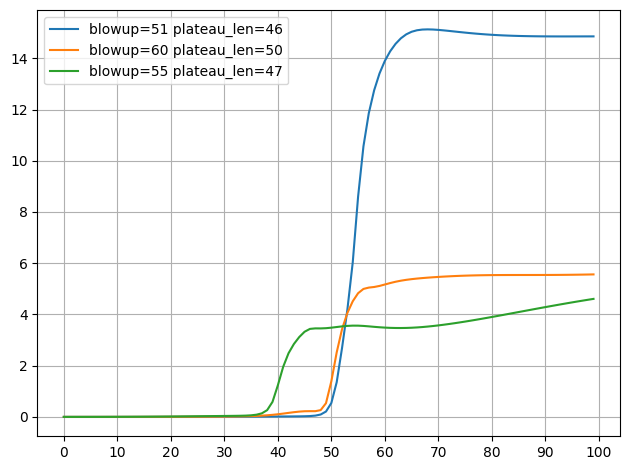

In [19]:
obs_idxs = [958, 4889, 3984]
steps = np.arange(0, 100, 1)

for obs_idx in obs_idxs:
    props = dict(df.loc[obs_idx])
    obs = raw_observations[obs_idx]
    label = (
        f"blowup={props['kl_div_blowup_step']} plateau_len={props['plateau_length']}"
    )
    plt.plot(steps, [s["kl_div"] for s in obs["steps"]], label=label)

plt.xticks(np.arange(0, 101, 10))
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()